In [2]:
import os 
import numpy as np
import re
import matplotlib.pyplot as plt
directory_changed = False 
try:
    from simulations.inhomogeneous import simulate_inhomogeneous_record
except:
    print("Adjusting path for imports..")
    os.chdir("..")
    directory_changed = True
    from simulations.inhomogeneous import simulate_inhomogeneous_record

import results
import data
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing
import csv
from pathlib import Path
from datetime import datetime
print(os.getcwd())
from scriptss.parallel_sims_rq3 import worker2

Adjusting path for imports..
c:\Users\rorka\PycharmProjects\AIHealth\CSS_project-19


# Simulating different Oak percentages on grid with a Slime distribution

In [3]:
base_dir = Path.cwd() / "data" / "slime_experiment"
base_dir.mkdir(parents=True, exist_ok=True)

# make a new experiment directory
idx = 1
while (base_dir / f"experiment_{idx}").exists():
    idx += 1
outdir = base_dir / f"experiment_{idx}"
outdir.mkdir(parents=True, exist_ok=False)
print(f" Results are stored in: {outdir}")

 Results are stored in: c:\Users\rorka\PycharmProjects\AIHealth\CSS_project-19\data\slime_experiment\experiment_10


In [4]:
# --- PARAMETERS ---
L = 256             # Grid grootte (512 is mooier, 256 is sneller)
p = 0.01            # Groeisnelheid
f = 0.0001          # Bliksemfrequentie
steps = 5000        # Minimaal 5000 voor SOC evenwicht!
runs_per_param = 5  # Aantal runs per oak ratio

# We testen weer dezelfde ratios om te kunnen vergelijken met het random model
oak_ratios = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
p_burn_oak = 0.3    # Eiken branden slecht

# Lijsten bouwen
param_list = []
param_idx = 1
param_map = {} # Handig om straks resultaten terug te vinden

for ratio in oak_ratios:
    param_map[param_idx] = ratio
    
    for run_idx in range(runs_per_param):
        param_list.append({
            'L': L, 'p': p, 'f': f, 'steps': steps,
            'oak_ratio': ratio,      # Dit gaat nu naar de Slime Mold generator
            'p_burn_oak': p_burn_oak,
            'param_id': param_idx,
            'run_id': run_idx
        })
    param_idx += 1

print(f"Ready for {len(param_list)} Slime Mold simulations to run.")
print(f"Variabel Oak Ratios: {oak_ratios}")

Ready for 30 Slime Mold simulations to run.
Variabel Oak Ratios: [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]


In [5]:
max_workers = multiprocessing.cpu_count()
print(f"🚀 Start with {max_workers} Processors...")

results = []
# Hier slaan we de data op per ratio: {0.2: [brand1, brand2...], 0.4: [...]}
fire_data_by_ratio = {ratio: [] for ratio in oak_ratios}

with ProcessPoolExecutor(max_workers=max_workers) as exe:
    # Submit alle taken aan worker2
    futures = {exe.submit(worker2, outdir, params): params for params in param_list}
    
    for fut in as_completed(futures):
        params = futures[fut]
        try:
            res = fut.result()
            
            # Welke ratio was dit?
            pid = params['param_id']
            ratio = param_map[pid]
            
            # Lees de ruwe data in vanuit de CSV die de worker heeft gemaakt
            raw_file = res.get('raw_file')
            if raw_file:
                current_fires = []
                with open(raw_file, 'r') as f:
                    reader = csv.reader(f)
                    next(reader) # Skip header
                    for row in reader:
                        if row: current_fires.append(int(row[0]))
                
                # Voeg toe aan de dataset voor deze ratio
                fire_data_by_ratio[ratio].extend(current_fires)
            
            print(f"✅ Klaar: Slime Mold Ratio {ratio:.1f}, Run {params['run_id']} -> {res['num_fires']} branden")
            results.append(res)
            
        except Exception as e:
            print(f"Error at params {params}: {e}")

print("🏁 All sims Finished")

🚀 Start with 8 Processors...
✅ Klaar: Slime Mold Ratio 0.2, Run 1 -> 15960 branden
✅ Klaar: Slime Mold Ratio 0.2, Run 0 -> 16237 branden
✅ Klaar: Slime Mold Ratio 0.2, Run 2 -> 16078 branden
✅ Klaar: Slime Mold Ratio 0.0, Run 0 -> 12452 branden
✅ Klaar: Slime Mold Ratio 0.0, Run 2 -> 12282 branden
✅ Klaar: Slime Mold Ratio 0.0, Run 4 -> 12375 branden
✅ Klaar: Slime Mold Ratio 0.0, Run 3 -> 12500 branden
✅ Klaar: Slime Mold Ratio 0.0, Run 1 -> 12307 branden
✅ Klaar: Slime Mold Ratio 0.6, Run 0 -> 22981 branden
✅ Klaar: Slime Mold Ratio 0.2, Run 4 -> 15981 branden
✅ Klaar: Slime Mold Ratio 0.4, Run 2 -> 19672 branden
✅ Klaar: Slime Mold Ratio 0.4, Run 0 -> 19580 branden
✅ Klaar: Slime Mold Ratio 0.4, Run 1 -> 19819 branden
✅ Klaar: Slime Mold Ratio 0.4, Run 3 -> 19657 branden
✅ Klaar: Slime Mold Ratio 0.2, Run 3 -> 16051 branden
✅ Klaar: Slime Mold Ratio 0.4, Run 4 -> 19473 branden
✅ Klaar: Slime Mold Ratio 0.6, Run 1 -> 23107 branden
✅ Klaar: Slime Mold Ratio 0.8, Run 3 -> 26908 branden

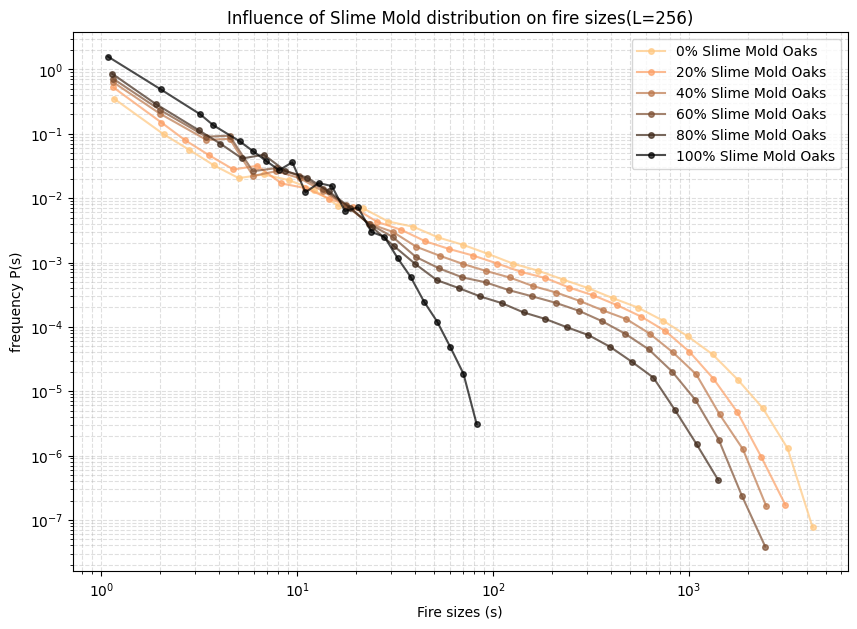

In [6]:
# --- PLOTTEN ---
plt.figure(figsize=(10, 7))

# Mooie kleuren van groen (weinig eiken) naar bruin/donker (veel eiken)
colors = plt.cm.copper(np.linspace(1, 0, len(oak_ratios)))

for idx, ratio in enumerate(sorted(oak_ratios)):
    fires = np.array(fire_data_by_ratio[ratio])
    
    # Filter 0 of hele kleine brandjes weg
    fires = fires[fires > 0]
    
    if len(fires) == 0:
        continue

    # Logarithmische bins
    min_s = 1
    max_s = fires.max()
    bins = np.logspace(np.log10(min_s), np.log10(max_s), num=30)
    
    hist, edges = np.histogram(fires, bins=bins, density=True)
    centers = np.sqrt(edges[:-1] * edges[1:])
    
    mask = hist > 0
    plt.loglog(centers[mask], hist[mask], 'o-', 
               label=f'{int(ratio*100)}% Slime Mold Oaks', 
               color=colors[idx], markersize=4, alpha=0.7)

plt.xlabel('Fire sizes (s)')
plt.ylabel('frequency P(s)')
plt.title(f'Influence of Slime Mold distribution on fire sizes(L={L})')
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.4)

plt.show()

Even geduld, slime mold is aan het tekenen...


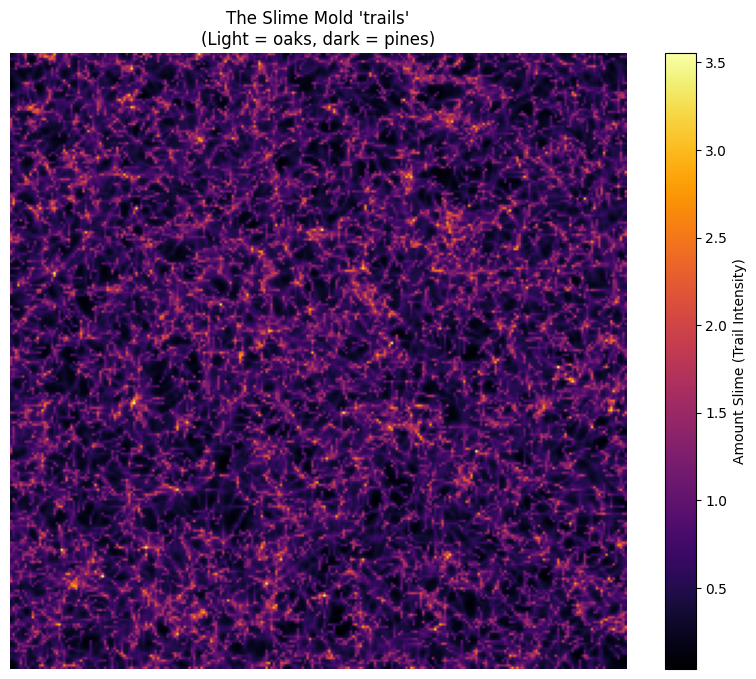

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter


def get_trails_for_plotting(L, ratio, steps=400):
    # 1. Instellingen
    num_agents = int(L * L * 0.08) 
    agents_x = np.random.rand(num_agents) * L
    agents_y = np.random.rand(num_agents) * L
    agents_angle = np.random.rand(num_agents) * 2 * np.pi
    trail_map = np.zeros((L, L))
    
    
    for _ in range(steps):
        # Move
        agents_x += np.cos(agents_angle)
        agents_y += np.sin(agents_angle)
        agents_x %= L
        agents_y %= L
        
        # Deposit
        ix = agents_x.astype(int)
        iy = agents_y.astype(int)
        np.add.at(trail_map, (ix, iy), 1.0)
        
        # Diffuse & Decay (deze instellingen bepalen de scherpte)
        trail_map = gaussian_filter(trail_map, sigma=0.4) * 0.90
        
        # Sense (simpel)
        agents_angle += (np.random.rand(num_agents) - 0.5) * 0.5

    return trail_map


print("Even geduld, slime mold is aan het tekenen...")


L_plot = 256
trails = get_trails_for_plotting(L=L_plot, ratio=0.4)


plt.figure(figsize=(10, 8))
plt.imshow(trails, cmap='inferno') # 'inferno', 'magma', of 'hot' zijn mooi hiervoor
plt.colorbar(label="Amount Slime (Trail Intensity)")
plt.title("The Slime Mold 'trails'\n(Light = oaks, dark = pines)")
plt.axis('off')
plt.show()

Genereren van kaarten met 40% Eiken...


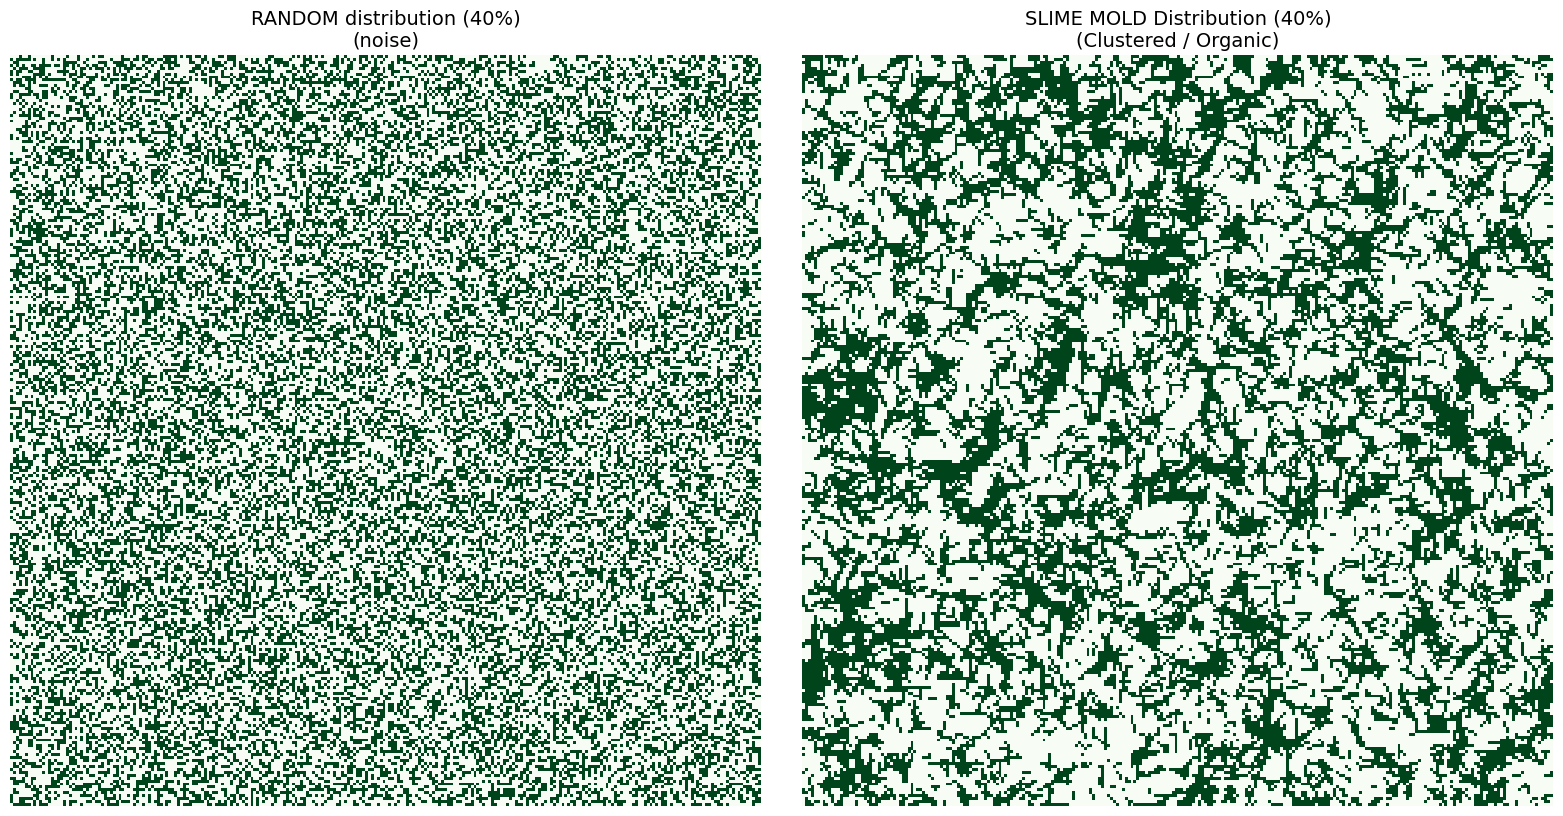

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# 1. De Functie voor Slime Mold (die hadden we al)
def get_slime_mask(L, ratio, steps=400):
    num_agents = int(L * L * 0.08) 
    agents_x = np.random.rand(num_agents) * L
    agents_y = np.random.rand(num_agents) * L
    agents_angle = np.random.rand(num_agents) * 2 * np.pi
    trail_map = np.zeros((L, L))
    
    for _ in range(steps):
        agents_x += np.cos(agents_angle); agents_y += np.sin(agents_angle)
        agents_x %= L; agents_y %= L
        np.add.at(trail_map, (agents_x.astype(int), agents_y.astype(int)), 1.0)
        trail_map = gaussian_filter(trail_map, sigma=0.4) * 0.90 # Scherpe settings
        agents_angle += (np.random.rand(num_agents) - 0.5) * 0.5
        
    threshold = np.percentile(trail_map.flatten(), 100 - (ratio * 100))
    return trail_map > threshold

# 2. De Functie voor Random (Heel simpel!)
def get_random_mask(L, ratio):
    # Maak een grid met willekeurige getallen tussen 0 en 1
    random_noise = np.random.rand(L, L)
    # Alles onder de 'ratio' wordt een Eik
    return random_noise < ratio

# --- DE VERGELIJKING PLOTTEN ---
L_plot = 256
ratio_plot = 0.4 # We kijken naar 40% Eiken

print(f"Genereren van kaarten met {int(ratio_plot*100)}% Eiken...")

# Maak de maskers
mask_slime = get_slime_mask(L_plot, ratio_plot)
mask_random = get_random_mask(L_plot, ratio_plot)

# Plotten
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Random Links
axes[0].imshow(mask_random, cmap='Greens', interpolation='nearest')
axes[0].set_title(f"RANDOM distribution ({int(ratio_plot*100)}%)\n(noise)", fontsize=14)
axes[0].axis('off')

# Slime Rechts
axes[1].imshow(mask_slime, cmap='Greens', interpolation='nearest')
axes[1].set_title(f"SLIME MOLD Distribution ({int(ratio_plot*100)}%)\n(Clustered / Organic)", fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()